In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing

In [2]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
# # NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
#     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#     #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

# print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Preprocess and Prepare Data

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join("../input/fire-segmentation-image-dataset/Image/Fire", id_name)
        mask_path = os.path.join("../input/fire-segmentation-image-dataset/Segmentation_Mask/Fire", id_name)
        # image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        # mask_path = os.path.join(self.path, id_name, "masks/")
        # all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        # for name in all_masks:
        #     _mask_path = mask_path + name
        #     _mask_image = cv2.imread(_mask_path, -1)
        #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        #     _mask_image = np.expand_dims(_mask_image, axis=-1)
        
        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        ## Normalizing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [5]:
image_size = 64
#image_size = 128
train_path = "../input/fire-segmentation-image-dataset/Image/Fire"
epochs = 1
# epochs = 10
batch_size = 10

## Training Ids
train_ids = next(os.walk(train_path))[2]

## Validation Data Size
val_data_size = 100

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
# print(valid_ids)
# print(train_ids)

In [6]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(10, 64, 64, 3) (10, 64, 64, 1)


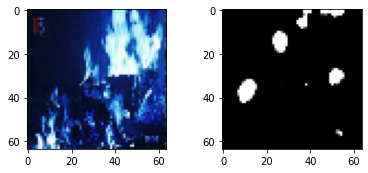

In [7]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# Model 1: UNet

In [8]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [17]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [18]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten(y_true)
    y_pred_f = tf.keras.layers.Flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [19]:
model = UNet()
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [20]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=10)

Epoch 1/10
2736/2736 [==============================] - 106s 38ms/step - loss: 0.0331 - mean_io_u_1: 0.4957 - val_loss: 0.0231 - val_mean_io_u_1: 0.4952
Epoch 2/10
2736/2736 [==============================] - 104s 38ms/step - loss: 0.0205 - mean_io_u_1: 0.4957 - val_loss: 0.0195 - val_mean_io_u_1: 0.4952
Epoch 3/10
2736/2736 [==============================] - 102s 37ms/step - loss: 0.0185 - mean_io_u_1: 0.4959 - val_loss: 0.0178 - val_mean_io_u_1: 0.4963
Epoch 4/10
2736/2736 [==============================] - 103s 38ms/step - loss: 0.0174 - mean_io_u_1: 0.4963 - val_loss: 0.0177 - val_mean_io_u_1: 0.4963
Epoch 5/10
2736/2736 [==============================] - 106s 39ms/step - loss: 0.0167 - mean_io_u_1: 0.4970 - val_loss: 0.0171 - val_mean_io_u_1: 0.4958
Epoch 6/10
2736/2736 [==============================] - 104s 38ms/step - loss: 0.0162 - mean_io_u_1: 0.4984 - val_loss: 0.0169 - val_mean_io_u_1: 0.4973
Epoch 7/10
2736/2736 [==============================] - 102s 37ms/step - loss: 0.0

In [21]:
## Save the Weights
model.save_weights("unet spot the fire.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

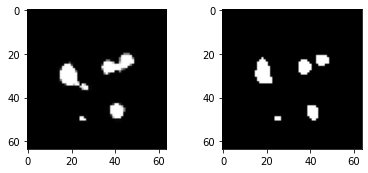

In [22]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

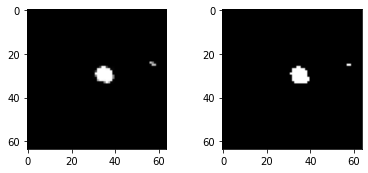

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

## Second training

In [41]:
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=20)

Epoch 1/20
2736/2736 [==============================] - 127s 46ms/step - loss: 0.0149 - mean_io_u_1: 0.5019 - val_loss: 0.0156 - val_mean_io_u_1: 0.5028
Epoch 2/20
2736/2736 [==============================] - 103s 38ms/step - loss: 0.0148 - mean_io_u_1: 0.5028 - val_loss: 0.0155 - val_mean_io_u_1: 0.4973
Epoch 3/20
2736/2736 [==============================] - 101s 37ms/step - loss: 0.0146 - mean_io_u_1: 0.5040 - val_loss: 0.0155 - val_mean_io_u_1: 0.5019
Epoch 4/20
2736/2736 [==============================] - 102s 37ms/step - loss: 0.0145 - mean_io_u_1: 0.5047 - val_loss: 0.0161 - val_mean_io_u_1: 0.5250
Epoch 5/20
2736/2736 [==============================] - 100s 37ms/step - loss: 0.0144 - mean_io_u_1: 0.5046 - val_loss: 0.0154 - val_mean_io_u_1: 0.4990
Epoch 6/20
2736/2736 [==============================] - 100s 36ms/step - loss: 0.0143 - mean_io_u_1: 0.5061 - val_loss: 0.0160 - val_mean_io_u_1: 0.5005
Epoch 7/20
2736/2736 [==============================] - 102s 37ms/step - loss: 0.0

In [43]:
## Save the Weights
model.save_weights("unet spot the fire 20 epochs.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

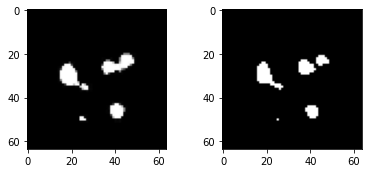

In [44]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

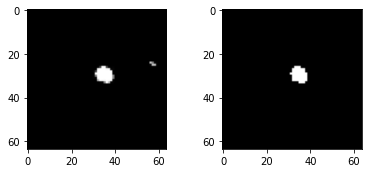

In [45]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

## Third training

In [152]:
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=30)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
## Save the Weights
model.save_weights("unet spot the fire 30 epochs.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

# Model 3: Attention Unet but failed

## **Encoder**

In [27]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

## **Decoder**

In [28]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

## **Attention Gate**

In [29]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [30]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

## **U Net Model**

In [38]:
# Inputs
input_layer = Input(shape=(128,128,3))

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model2 = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

In [39]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encoder1 (EncoderBlock)         ((None, 64, 64, 32), 10144       input_5[0][0]                    
__________________________________________________________________________________________________
Encoder2 (EncoderBlock)         ((None, 32, 32, 64), 55424       Encoder1[0][0]                   
__________________________________________________________________________________________________
Encoder3 (EncoderBlock)         ((None, 16, 16, 128) 221440      Encoder2[0][0]                   
____________________________________________________________________________________________

In [40]:
# Config Training
BATCH_SIZE = 8

results = model2.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=15)

Epoch 1/15


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  required broadcastable shapes
	 [[node model_4/Attention1/multiply/mul (defined at tmp/ipykernel_23/554259654.py:23) ]]
	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_39]]
  (1) Invalid argument:  required broadcastable shapes
	 [[node model_4/Attention1/multiply/mul (defined at tmp/ipykernel_23/554259654.py:23) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_77380]

Errors may have originated from an input operation.
Input Source operations connected to node model_4/Attention1/multiply/mul:
 model_4/Attention1/up_sampling2d_24/resize/ResizeNearestNeighbor (defined at tmp/ipykernel_23/554259654.py:22)	
 model_4/Encoder4/conv2d_107/Relu (defined at tmp/ipykernel_23/4139342186.py:18)

Input Source operations connected to node model_4/Attention1/multiply/mul:
 model_4/Attention1/up_sampling2d_24/resize/ResizeNearestNeighbor (defined at tmp/ipykernel_23/554259654.py:22)	
 model_4/Encoder4/conv2d_107/Relu (defined at tmp/ipykernel_23/4139342186.py:18)

Function call stack:
train_function -> train_function
